In [0]:
# used for histogram plotting
%pip install pyspark_dist_explore

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Importing packages
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains, lit, min, max, mean, year, desc
from pyspark.sql.functions import *	
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from itertools import product
from pyspark.sql.window import Window
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

Out[1]: DataFrame[key: string, value: string]

## 1.1

In [0]:
# reading in the data
txn = spark.read.options(header='True', delimiter=',').csv("/FileStore/tables/Retail_Data_Transactions.csv")
txn.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- trans_date: string (nullable = true)
 |-- tran_amount: string (nullable = true)



In [0]:
# checking that txn has 125000 rows
txn.count()

Out[3]: 125000

In [0]:
# converting the string to an actual timestamp
txn = txn.withColumn('txn_dates', to_timestamp('trans_date','dd-MMM-yy')).withColumn('txn_date', to_date('txn_dates')).drop('trans_date', 'txn_dates')
txn.show()

+-----------+-----------+----------+
|customer_id|tran_amount|  txn_date|
+-----------+-----------+----------+
|     CS5295|         35|2013-02-11|
|     CS4768|         39|2015-03-15|
|     CS2122|         52|2013-02-26|
|     CS1217|         99|2011-11-16|
|     CS1850|         78|2013-11-20|
|     CS5539|         81|2014-03-26|
|     CS2724|         93|2012-02-06|
|     CS5902|         89|2015-01-30|
|     CS6040|         76|2013-01-08|
|     CS3802|         75|2013-08-20|
|     CS3494|         94|2013-07-02|
|     CS3780|         80|2013-03-25|
|     CS1171|         59|2012-11-03|
|     CS2892|         43|2013-05-12|
|     CS5552|         78|2014-12-29|
|     CS6043|         98|2014-01-15|
|     CS4147|         81|2013-07-08|
|     CS4655|         93|2013-12-30|
|     CS3904|        103|2014-07-20|
|     CS4102|         96|2011-07-09|
+-----------+-----------+----------+
only showing top 20 rows



In [0]:
# showing the min and max dates under 'txn_date'
txn.select(max("txn_date")).show()
txn.select(min("txn_date")).show()

+-------------+
|max(txn_date)|
+-------------+
|   2015-03-16|
+-------------+

+-------------+
|min(txn_date)|
+-------------+
|   2011-05-16|
+-------------+



In [0]:
# creating the 'ME_DT' column from the last day of the month
txn = txn.withColumn('ME_DT', last_day('txn_date'))
txn.show()

+-----------+-----------+----------+----------+
|customer_id|tran_amount|  txn_date|     ME_DT|
+-----------+-----------+----------+----------+
|     CS5295|         35|2013-02-11|2013-02-28|
|     CS4768|         39|2015-03-15|2015-03-31|
|     CS2122|         52|2013-02-26|2013-02-28|
|     CS1217|         99|2011-11-16|2011-11-30|
|     CS1850|         78|2013-11-20|2013-11-30|
|     CS5539|         81|2014-03-26|2014-03-31|
|     CS2724|         93|2012-02-06|2012-02-29|
|     CS5902|         89|2015-01-30|2015-01-31|
|     CS6040|         76|2013-01-08|2013-01-31|
|     CS3802|         75|2013-08-20|2013-08-31|
|     CS3494|         94|2013-07-02|2013-07-31|
|     CS3780|         80|2013-03-25|2013-03-31|
|     CS1171|         59|2012-11-03|2012-11-30|
|     CS2892|         43|2013-05-12|2013-05-31|
|     CS5552|         78|2014-12-29|2014-12-31|
|     CS6043|         98|2014-01-15|2014-01-31|
|     CS4147|         81|2013-07-08|2013-07-31|
|     CS4655|         93|2013-12-30|2013

In [0]:
# creating year column
txn = txn.withColumn('YEAR', year('txn_date'))
txn.show()

+-----------+-----------+----------+----------+----+
|customer_id|tran_amount|  txn_date|     ME_DT|YEAR|
+-----------+-----------+----------+----------+----+
|     CS5295|         35|2013-02-11|2013-02-28|2013|
|     CS4768|         39|2015-03-15|2015-03-31|2015|
|     CS2122|         52|2013-02-26|2013-02-28|2013|
|     CS1217|         99|2011-11-16|2011-11-30|2011|
|     CS1850|         78|2013-11-20|2013-11-30|2013|
|     CS5539|         81|2014-03-26|2014-03-31|2014|
|     CS2724|         93|2012-02-06|2012-02-29|2012|
|     CS5902|         89|2015-01-30|2015-01-31|2015|
|     CS6040|         76|2013-01-08|2013-01-31|2013|
|     CS3802|         75|2013-08-20|2013-08-31|2013|
|     CS3494|         94|2013-07-02|2013-07-31|2013|
|     CS3780|         80|2013-03-25|2013-03-31|2013|
|     CS1171|         59|2012-11-03|2012-11-30|2012|
|     CS2892|         43|2013-05-12|2013-05-31|2013|
|     CS5552|         78|2014-12-29|2014-12-31|2014|
|     CS6043|         98|2014-01-15|2014-01-31

## 1.2

In [0]:
# initializing aggregation functions
sum_ann = sum('tran_amount')
mean = avg('tran_amount')
std = stddev('tran_amount')
var = variance('tran_amount')
max_ann = max('tran_amount')
min_ann = min('tran_amount')
count = countDistinct('tran_amount', 'customer_id')
sem = std/sqrt(count)

In [0]:
# performing aggregation
clnt_annual_aggregations = txn.groupBy("customer_id","YEAR")\
.agg(sum_ann.alias("ann_txn_amt_sum"),\
       mean.alias("ann_txn_amt_avg"),\
       std.alias("ann_txn_amt_std"),\
       var.alias("ann_txn_amt_var"),\
       sem.alias("ann_txn_amt_sem"),\
       max_ann.alias("ann_txn_amt_max"),\
       min_ann.alias("ann_txn_amt_min"),\
       count.alias("ann_txn_amt_cnt"))

# converting max and min to doubles such that it can be modified in pyspark
clnt_annual_aggregations = clnt_annual_aggregations.withColumn("ann_txn_amt_max",clnt_annual_aggregations.ann_txn_amt_max.cast('double'))
clnt_annual_aggregations = clnt_annual_aggregations.withColumn("ann_txn_amt_min",clnt_annual_aggregations.ann_txn_amt_min.cast('double'))

In [0]:
clnt_annual_aggregations.show()

+-----------+----+---------------+-----------------+------------------+------------------+------------------+---------------+---------------+---------------+
|customer_id|YEAR|ann_txn_amt_sum|  ann_txn_amt_avg|   ann_txn_amt_std|   ann_txn_amt_var|   ann_txn_amt_sem|ann_txn_amt_max|ann_txn_amt_min|ann_txn_amt_cnt|
+-----------+----+---------------+-----------------+------------------+------------------+------------------+---------------+---------------+---------------+
|     CS1112|2011|          212.0|70.66666666666667| 22.03028218914441| 485.3333333333333|12.719189352225943|           96.0|           56.0|              3|
|     CS1112|2012|          337.0|             67.4|12.720062892926277|             161.8| 5.688585061331157|           81.0|           52.0|              5|
|     CS1112|2013|          212.0|70.66666666666667| 34.50120770833006|1190.3333333333335| 19.91928155777155|           71.0|          105.0|              3|
|     CS1112|2014|          212.0|70.66666666666667|

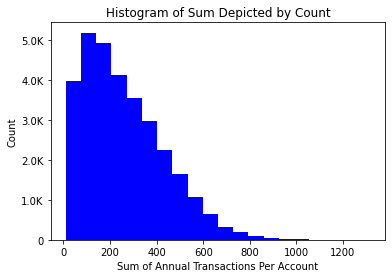

In [0]:
# histogram plotting
fig, ax = plt.subplots()
# hist is a pyspark api developed for this use
hist(ax, clnt_annual_aggregations.select('ann_txn_amt_sum'), bins = 20, color=['blue'])
plt.xlabel("Sum of Annual Transactions Per Account")
plt.ylabel("Count")
plt.title("Histogram of Sum Depicted by Count")
plt.show()

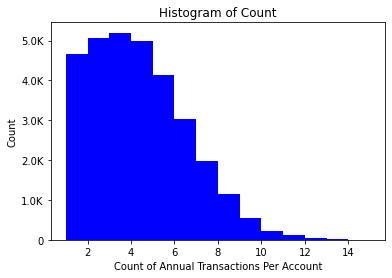

In [0]:
# histogram plotting
fig, ax = plt.subplots()
# hist is a pyspark api developed for this use
hist(ax, clnt_annual_aggregations.select('ann_txn_amt_cnt'), bins = 14, color=['blue'])
plt.xlabel("Count of Annual Transactions Per Account")
plt.ylabel("Count")
plt.title("Histogram of Count")
plt.show()

In [0]:
# pivoting the clnt_annual_aggregations table to show data per year. There is no multi-index in pyspark so the year is appended in front of each label
clnt_annual_aggregations_pivot = clnt_annual_aggregations.groupBy('customer_id').pivot('YEAR')\
.agg(F.sum("ann_txn_amt_sum").alias("ann_txn_amt_sum"), F.sum("ann_txn_amt_avg").alias("ann_txn_amt_avg"), F.sum("ann_txn_amt_std").alias("ann_txn_amt_std"), F.sum("ann_txn_amt_var").alias("ann_txn_amt_var"), F.sum("ann_txn_amt_sem").alias("ann_txn_amt_sem"), F.sum("ann_txn_amt_max").alias("ann_txn_amt_max"), F.sum("ann_txn_amt_min").alias("ann_txn_amt_min"), F.sum("ann_txn_amt_cnt").alias("ann_txn_amt_cnt"))\
.fillna(0).orderBy(asc("customer_id"))

There are 40 columns b/c there are 5 years with 8 categories -> 5x8 = 40. Zero was chosen to fill the NaN values as they represent some type of continuous information, since the NaN values are associated with no count, it means that there is no data at all for these categories and filling with zero is appropriate.

As said above, pyspark dataframes do not support multi-indexing, the "would-be" two levels are already merged based on the pivot method. Here the year name is merged with each respective aggfunc. 1.2.5 is also redundant in pyspark as the dataframe interprets the merge of the 'multi-levels'.

In [0]:
clnt_annual_aggregations_pivot.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|customer_id|2011_ann_txn_amt_sum|2011_ann_txn_amt_avg|2011_ann_txn_amt_std|2011_ann_txn_amt_var|2011_ann_txn_amt_sem|2011_ann_txn_amt_max|2011_an

In [0]:
# pyspark dataframes do not have an index, thus the original 'index' from pandas is now included as a column. 40 information columns + 1 index column = 41 columns
len(clnt_annual_aggregations_pivot.columns)

Out[15]: 41

In [0]:
# pyspark does not have a direct method of writing to .xlsx format and would require a pandas dataframe. Additionally the data does not export properly on databricks if using the pandas export.
# this (all csv write commands in this code) needs to be commented out if the whole program was to run again.
# clnt_annual_aggregations_pivot.coalesce(1).write.format("com.databricks.spark.csv").save("/FileStore/tables/annual_features_1.csv", header = 'true')

1.2.6 - The disadvantages of capturing the client transaction behaviour in this manner is the ability for the interpreter to understand the information in regards to the other sections of data. Given that these are separated by year with their descriptive statistic, it may be difficult for the interpreter to get a full sense of each client's historical transactions. Additionally, it would be difficult to capture data in a shorter time frame and understand actual spending habits of each account.

## 1.3

In [0]:
clnt_monthly_aggregations = txn.groupBy("customer_id","ME_DT")\
.agg(sum_ann.alias("mth_txn_amt_sum"),\
       count.alias("mth_txn_cnt"))

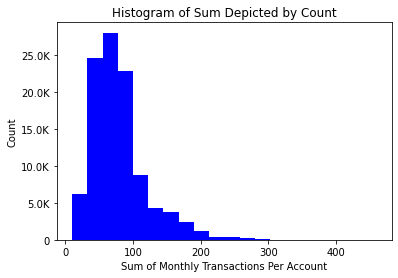

In [0]:
fig, ax = plt.subplots()
hist(ax, clnt_monthly_aggregations.select('mth_txn_amt_sum'), bins = 20, color=['blue'])
plt.xlabel("Sum of Monthly Transactions Per Account")
plt.ylabel("Count")
plt.title("Histogram of Sum Depicted by Count")
plt.show()

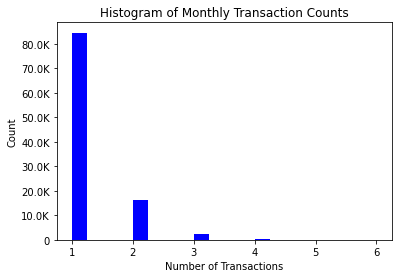

In [0]:
fig, ax = plt.subplots()
hist(ax, clnt_monthly_aggregations.select('mth_txn_cnt'), bins = 20, color=['blue'])
plt.xlabel("Number of Transactions")
plt.ylabel("Count")
plt.title("Histogram of Monthly Transaction Counts")
plt.show()

The most common monthly transactions made is 1 transaction with a max above 80k users. The sum of the monthly transactions totalled to the most common amount '<'100$ and max of 25+k people belong in that bucket. In the yearly histogram, the sum of the transactions were closer to 100-200, meaning that a lot of the money is being removed from the account in one transaction. This is reflected in the count histogram as we can see that the monthly transactions mostly have one transaction and the peak transactions per year was 4, with around 5k users.

In [0]:
# double checking that the data is correct
clnt_monthly_aggregations.where(clnt_monthly_aggregations.customer_id=='CS1112').orderBy(asc("ME_DT")).show()

+-----------+----------+---------------+-----------+
|customer_id|     ME_DT|mth_txn_amt_sum|mth_txn_cnt|
+-----------+----------+---------------+-----------+
|     CS1112|2011-06-30|           56.0|          1|
|     CS1112|2011-08-31|           96.0|          1|
|     CS1112|2011-10-31|           60.0|          1|
|     CS1112|2012-04-30|           56.0|          1|
|     CS1112|2012-06-30|           52.0|          1|
|     CS1112|2012-07-31|           81.0|          1|
|     CS1112|2012-09-30|           72.0|          1|
|     CS1112|2012-12-31|           76.0|          1|
|     CS1112|2013-03-31|          105.0|          1|
|     CS1112|2013-07-31|           36.0|          1|
|     CS1112|2013-11-30|           71.0|          1|
|     CS1112|2014-04-30|           63.0|          1|
|     CS1112|2014-07-31|           90.0|          1|
|     CS1112|2014-12-31|           59.0|          1|
|     CS1112|2015-01-31|           39.0|          1|
+-----------+----------+---------------+------

## 1.4

### base table generation

In [0]:
cust_unique = txn.select('customer_id').distinct()
date_unique = txn.select('ME_DT').distinct()

In [0]:
# checking that the dimensions of the base table will be correct
cust_unique.count()

Out[22]: 6889

In [0]:
date_unique.count()

Out[23]: 47

In [0]:
# cross join is the pyspark version of the product command in pandas
base_table = cust_unique.crossJoin(date_unique)
base_table = base_table.withColumnRenamed('customer_id', 'CLNT_NO')

In [0]:
base_table.show()

+-------+----------+
|CLNT_NO|     ME_DT|
+-------+----------+
| CS6043|2013-03-31|
| CS4147|2013-03-31|
| CS5539|2013-03-31|
| CS1217|2013-03-31|
| CS1171|2013-03-31|
| CS2724|2013-03-31|
| CS3802|2013-03-31|
| CS3780|2013-03-31|
| CS5902|2013-03-31|
| CS3494|2013-03-31|
| CS1850|2013-03-31|
| CS5552|2013-03-31|
| CS4655|2013-03-31|
| CS4768|2013-03-31|
| CS2892|2013-03-31|
| CS3904|2013-03-31|
| CS5295|2013-03-31|
| CS6040|2013-03-31|
| CS2086|2013-03-31|
| CS4102|2013-03-31|
+-------+----------+
only showing top 20 rows



In [0]:
# counting that account CS1112 has 47 rows
var_CS1112 = base_table.where(base_table.CLNT_NO=='CS1112')
var_CS1112.count()

Out[26]: 47

In [0]:
# checking the min and max date in the base table and  making sure it contains all the info
col_earlist_date = F.min('ME_DT').alias('earliest')
col_latest_date = F.max('ME_DT').alias('latest')
df_result = var_CS1112.select(col_earlist_date, col_latest_date)
df_result.show()

+----------+----------+
|  earliest|    latest|
+----------+----------+
|2011-05-31|2015-03-31|
+----------+----------+



In [0]:
#checking base table dimensions
base_table.count()

Out[28]: 323783

In [0]:
len(base_table.columns)

Out[29]: 2

## 1.5

In [0]:
clnt_monthly_aggregations = clnt_monthly_aggregations.withColumnRenamed('ME_DT', 'ME_DT_2')
base_clnt_mth = base_table.join(clnt_monthly_aggregations, [base_table.CLNT_NO ==  clnt_monthly_aggregations.customer_id,\
                                                              base_table.ME_DT ==  clnt_monthly_aggregations.ME_DT_2],"left")
base_clnt_mth = base_clnt_mth.drop("customer_id", "ME_DT_2").orderBy("CLNT_NO", "ME_DT")

In [0]:
# pyspark handles all 'NA-' type data as null objects
base_clnt_mth.show()

+-------+----------+---------------+-----------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum|mth_txn_cnt|
+-------+----------+---------------+-----------+
| CS1112|2011-05-31|           null|       null|
| CS1112|2011-06-30|           56.0|          1|
| CS1112|2011-07-31|           null|       null|
| CS1112|2011-08-31|           96.0|          1|
| CS1112|2011-09-30|           null|       null|
| CS1112|2011-10-31|           60.0|          1|
| CS1112|2011-11-30|           null|       null|
| CS1112|2011-12-31|           null|       null|
| CS1112|2012-01-31|           null|       null|
| CS1112|2012-02-29|           null|       null|
| CS1112|2012-03-31|           null|       null|
| CS1112|2012-04-30|           56.0|          1|
| CS1112|2012-05-31|           null|       null|
| CS1112|2012-06-30|           52.0|          1|
| CS1112|2012-07-31|           81.0|          1|
| CS1112|2012-08-31|           null|       null|
| CS1112|2012-09-30|           72.0|          1|
| CS1112|2012-10-31|

Rows have null values because those dates created by the base table may not actually have transactions for every account. To impute these values, 0 will be used as these accounts have not made a transaction in those time periods, and mean/mode values would not be representative of the data of each account. Imputing the values with non-zero values may also skew the data and desired results of this analysis.

In [0]:
# pyspark method of counting nulls
from pyspark.sql.functions import col, when, count
base_clnt_mth.select([count(when(col(c).isNull() , c)).alias(c) for c in base_clnt_mth.columns]
   ).show()

+-------+-----+---------------+-----------+
|CLNT_NO|ME_DT|mth_txn_amt_sum|mth_txn_cnt|
+-------+-----+---------------+-----------+
|      0|    0|         220549|     220549|
+-------+-----+---------------+-----------+



In [0]:
base_clnt_mth = base_clnt_mth.fillna(0)

base_clnt_mth is different from clnt_monthly_aggregations because base_clnt_mth includes all possible dates of transactions and clnt_monthly_aggregations only contain dates where transactions occured for each individual account. base_clnt_mth provides a more comparable dataset as it contains all the dates for every account.

In [0]:
base_clnt_mth = base_clnt_mth.orderBy("CLNT_NO", "ME_DT")

In [0]:
base_clnt_mth.show()

+-------+----------+---------------+-----------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum|mth_txn_cnt|
+-------+----------+---------------+-----------+
| CS1112|2011-05-31|            0.0|          0|
| CS1112|2011-06-30|           56.0|          1|
| CS1112|2011-07-31|            0.0|          0|
| CS1112|2011-08-31|           96.0|          1|
| CS1112|2011-09-30|            0.0|          0|
| CS1112|2011-10-31|           60.0|          1|
| CS1112|2011-11-30|            0.0|          0|
| CS1112|2011-12-31|            0.0|          0|
| CS1112|2012-01-31|            0.0|          0|
| CS1112|2012-02-29|            0.0|          0|
| CS1112|2012-03-31|            0.0|          0|
| CS1112|2012-04-30|           56.0|          1|
| CS1112|2012-05-31|            0.0|          0|
| CS1112|2012-06-30|           52.0|          1|
| CS1112|2012-07-31|           81.0|          1|
| CS1112|2012-08-31|            0.0|          0|
| CS1112|2012-09-30|           72.0|          1|
| CS1112|2012-10-31|

In [0]:
base_clnt_mth.printSchema()

root
 |-- CLNT_NO: string (nullable = true)
 |-- ME_DT: date (nullable = true)
 |-- mth_txn_amt_sum: double (nullable = false)
 |-- mth_txn_cnt: long (nullable = true)



In [0]:
base_clnt_mth = base_clnt_mth.withColumn('ME_DT', base_clnt_mth.ME_DT.cast('timestamp'))
# w2 is a general window for removing the first expected null values, reason explained below
w2 = Window.partitionBy("CLNT_NO").orderBy(col("ME_DT"))
w3 = Window.partitionBy('CLNT_NO').orderBy(F.col("ME_DT").cast('long')).rowsBetween(-2, 0)
rolling_features_3M = base_clnt_mth.withColumn('amt sum 3M', F.sum("mth_txn_amt_sum").over(w3)).withColumn('amt mean 3M', F.avg(F.col("mth_txn_amt_sum")).over(w3)).withColumn('amt max 3M', F.max("mth_txn_amt_sum").over(w3))\
.withColumn('txn cnt sum 3M', F.sum("mth_txn_cnt").over(w3)).withColumn('txn cnt mean 3M', F.avg("mth_txn_cnt").over(w3)).withColumn('txn cnt max 3M', F.max("mth_txn_cnt").over(w3))\
.orderBy("CLNT_NO", "ME_DT")\
.drop("mth_txn_amt_sum", "mth_txn_cnt")
# dropping the first 2 months where it is expected to be null values
rolling_features_3M = rolling_features_3M.withColumn("row",row_number().over(w2)).filter(col("row") > 2).drop("row")
w6 = (Window.partitionBy('CLNT_NO').orderBy(F.col("ME_DT").cast('long')).rowsBetween(-5, 0))
rolling_features_6M = base_clnt_mth.withColumn('amt sum 6M', F.sum("mth_txn_amt_sum").over(w6)).withColumn('amt mean 6M', F.avg("mth_txn_amt_sum").over(w6)).withColumn('amt max 6M', F.max("mth_txn_amt_sum").over(w6))\
.withColumn('txn cnt sum 6M', F.sum("mth_txn_cnt").over(w6)).withColumn('txn cnt mean 6M', F.avg("mth_txn_cnt").over(w6)).withColumn('txn cnt max 6M', F.max("mth_txn_cnt").over(w6))\
.orderBy("CLNT_NO", "ME_DT")\
.drop("mth_txn_amt_sum", "mth_txn_cnt")
# dropping the first 5 months where it is expected to be null values
rolling_features_6M = rolling_features_6M.withColumn("row",row_number().over(w2)).filter(col("row") > 5).drop("row")
w12 = (Window.partitionBy('CLNT_NO').orderBy(F.col("ME_DT").cast('long')).rowsBetween(-11, 0))
rolling_features_12M = base_clnt_mth.withColumn('amt sum 12M', F.sum("mth_txn_amt_sum").over(w12)).withColumn('amt mean 12M', F.avg("mth_txn_amt_sum").over(w12)).withColumn('amt max 12M', F.max("mth_txn_amt_sum").over(w12)).withColumn('txn cnt sum 12M', F.sum("mth_txn_cnt").over(w12)).withColumn('txn cnt mean 12M', F.avg("mth_txn_cnt").over(w12)).withColumn('txn cnt max 12M', F.max("mth_txn_cnt").over(w12))\
.orderBy("CLNT_NO", "ME_DT")\
.drop("mth_txn_amt_sum", "mth_txn_cnt")
# dropping the first 11 months where it is expected to be null values
rolling_features_12M = rolling_features_12M.withColumn("row",row_number().over(w2)).filter(col("row") > 11).drop("row")

In [0]:
rolling_features_3M.show()

+-------+-------------------+----------+------------------+----------+--------------+------------------+--------------+
|CLNT_NO|              ME_DT|amt sum 3M|       amt mean 3M|amt max 3M|txn cnt sum 3M|   txn cnt mean 3M|txn cnt max 3M|
+-------+-------------------+----------+------------------+----------+--------------+------------------+--------------+
| CS1112|2011-07-31 00:00:00|      56.0|18.666666666666668|      56.0|             1|0.3333333333333333|             1|
| CS1112|2011-08-31 00:00:00|     152.0|50.666666666666664|      96.0|             2|0.6666666666666666|             1|
| CS1112|2011-09-30 00:00:00|      96.0|              32.0|      96.0|             1|0.3333333333333333|             1|
| CS1112|2011-10-31 00:00:00|     156.0|              52.0|      96.0|             2|0.6666666666666666|             1|
| CS1112|2011-11-30 00:00:00|      60.0|              20.0|      60.0|             1|0.3333333333333333|             1|
| CS1112|2011-12-31 00:00:00|      60.0|

Pyspark does not give the expected null values when compiling the rolling window table. This may be caused by how the rolling window works where it will still attempt the calculation with the available data. In this case, it will use the previous NaN positions from pandas and attempt to interpret some rolling number. After the expected cut-off points (row 2, 5, and 11 for 3M, 6M and 12M) the data behaves as expected. Similarly, the multi-index is not available and the column names are specified.

In [0]:
# The renaming of columns is done because pyspark will allow merge of the same column names but then later unable to differentiate which column to remove.
rolling_features_3M = rolling_features_3M.withColumnRenamed('ME_DT', 'ME_DT_1')
rolling_features_3M = rolling_features_3M.withColumnRenamed('CLNT_NO', 'CLNT_NO_1')
rolling_features_6M = rolling_features_6M.withColumnRenamed('ME_DT', 'ME_DT_2')
rolling_features_6M = rolling_features_6M.withColumnRenamed('CLNT_NO', 'CLNT_NO_2')
merged_df_3_6 = rolling_features_3M.join(rolling_features_6M, [rolling_features_3M.CLNT_NO_1 == rolling_features_6M.CLNT_NO_2, rolling_features_3M.ME_DT_1 ==  rolling_features_6M.ME_DT_2],"full")
rolling_features_12M = rolling_features_12M.withColumnRenamed('ME_DT', 'ME_DT_3')
rolling_features_12M = rolling_features_12M.withColumnRenamed('CLNT_NO', 'CLNT_NO_3')
merged_df_3_6_12 = merged_df_3_6.join(rolling_features_12M, [merged_df_3_6.CLNT_NO_1 == rolling_features_12M.CLNT_NO_3, merged_df_3_6.ME_DT_1 ==  rolling_features_12M.ME_DT_3],"full")
merged_df = base_clnt_mth.join(merged_df_3_6_12, [base_clnt_mth.CLNT_NO == merged_df_3_6_12.CLNT_NO_1,\
                                                  base_clnt_mth.ME_DT ==  merged_df_3_6_12.ME_DT_1],"full").orderBy("CLNT_NO", "ME_DT").drop("ME_DT" ,"ME_DT_1", "ME_DT_2", "ME_DT_3", "CLNT_NO_1", "CLNT_NO_2", "CLNT_NO_3")

In [0]:
merged_df.show()

+-------+---------------+-----------+----------+------------------+----------+--------------+------------------+--------------+----------+------------------+----------+--------------+-------------------+--------------+-----------+------------------+-----------+---------------+------------------+---------------+
|CLNT_NO|mth_txn_amt_sum|mth_txn_cnt|amt sum 3M|       amt mean 3M|amt max 3M|txn cnt sum 3M|   txn cnt mean 3M|txn cnt max 3M|amt sum 6M|       amt mean 6M|amt max 6M|txn cnt sum 6M|    txn cnt mean 6M|txn cnt max 6M|amt sum 12M|      amt mean 12M|amt max 12M|txn cnt sum 12M|  txn cnt mean 12M|txn cnt max 12M|
+-------+---------------+-----------+----------+------------------+----------+--------------+------------------+--------------+----------+------------------+----------+--------------+-------------------+--------------+-----------+------------------+-----------+---------------+------------------+---------------+
| CS1112|            0.0|          0|      null|             

In [0]:
merged_df.count()

Out[41]: 323783

In [0]:
# there are only 21 columns because the previous existing index label column does not exist in pyspark. 
len(merged_df.columns)

Out[42]: 21

In [0]:
# merged_df.coalesce(1).write.format("com.databricks.spark.csv").save("/FileStore/tables/mth_rolling_features_2.csv", header = 'true')

## 1.6

In [0]:
# day of the week and name conversion
from pyspark.sql.functions import date_format
txn = txn.withColumn('day_of_the_week', date_format('txn_date', 'u')).withColumn('day_name', date_format('txn_date', 'E'))
txn.show()

+-----------+-----------+----------+----------+----+---------------+--------+
|customer_id|tran_amount|  txn_date|     ME_DT|YEAR|day_of_the_week|day_name|
+-----------+-----------+----------+----------+----+---------------+--------+
|     CS5295|         35|2013-02-11|2013-02-28|2013|              1|     Mon|
|     CS4768|         39|2015-03-15|2015-03-31|2015|              7|     Sun|
|     CS2122|         52|2013-02-26|2013-02-28|2013|              2|     Tue|
|     CS1217|         99|2011-11-16|2011-11-30|2011|              3|     Wed|
|     CS1850|         78|2013-11-20|2013-11-30|2013|              3|     Wed|
|     CS5539|         81|2014-03-26|2014-03-31|2014|              3|     Wed|
|     CS2724|         93|2012-02-06|2012-02-29|2012|              1|     Mon|
|     CS5902|         89|2015-01-30|2015-01-31|2015|              5|     Fri|
|     CS6040|         76|2013-01-08|2013-01-31|2013|              2|     Tue|
|     CS3802|         75|2013-08-20|2013-08-31|2013|            

In [0]:
day = txn.groupBy('day_of_the_week').count().orderBy('day_of_the_week')

In [0]:
day.show()

+---------------+-----+
|day_of_the_week|count|
+---------------+-----+
|              1|17885|
|              2|18031|
|              3|18028|
|              4|17796|
|              5|17590|
|              6|17929|
|              7|17741|
+---------------+-----+



In [0]:
# creating numpy arrays from each of the extracted data of day names and counts to plot the bar plot
weekdays = txn.select('day_name').distinct().orderBy('day_of_the_week').collect()
weekdays = [v['day_name'] for v in weekdays]
day_count = day.select('count').collect()
day_count = [v['count'] for v in day_count]

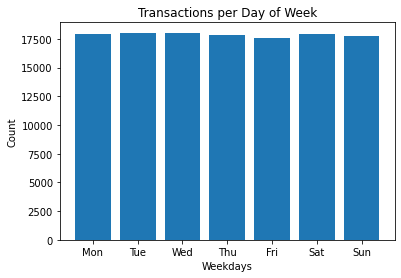

In [0]:
plt.bar(weekdays, day_count)
plt.xlabel("Weekdays")
plt.ylabel("Count")
plt.title("Transactions per Day of Week")
plt.show()

In [0]:
# performing the aggregation and joining the names of the multi-index
count = countDistinct('tran_amount', 'customer_id')
clnt_day_of_week = txn.groupBy("customer_id","YEAR", "day_name")\
.agg(count.alias("ann_txn_amt_cnt"))
clnt_day_of_week = clnt_day_of_week.withColumn('Year_day', concat_ws("_",clnt_day_of_week.YEAR,clnt_day_of_week.day_name))
clnt_day_of_week_pivot = clnt_day_of_week.groupBy('customer_id').pivot('Year_day').sum("ann_txn_amt_cnt").fillna(0).orderBy(asc("customer_id"))

In [0]:
clnt_day_of_week_pivot.show()

+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|customer_id|2011_Fri|2011_Mon|2011_Sat|2011_Sun|2011_Thu|2011_Tue|2011_Wed|2012_Fri|2012_Mon|2012_Sat|2012_Sun|2012_Thu|2012_Tue|2012_Wed|2013_Fri|2013_Mon|2013_Sat|2013_Sun|2013_Thu|2013_Tue|2013_Wed|2014_Fri|2014_Mon|2014_Sat|2014_Sun|2014_Thu|2014_Tue|2014_Wed|2015_Fri|2015_Mon|2015_Sat|2015_Sun|2015_Thu|2015_Tue|2015_Wed|
+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     CS1112|

In [0]:
# clnt_day_of_week_pivot.coalesce(1).write.format("com.databricks.spark.csv").save("/FileStore/tables/annual_day_of_week_counts.csv", header = 'true')

In [0]:
# creating dataframe for per-day basis
clnt_day = txn.groupBy("customer_id","ME_DT", "day_name")\
.agg(count.alias("ann_txn_amt_cnt"))
clnt_day_pivot = clnt_day.groupBy('customer_id', 'ME_DT').pivot('day_name').sum("ann_txn_amt_cnt").fillna(0).orderBy("customer_id", "ME_DT")

In [0]:
clnt_day_pivot.show()

+-----------+----------+---+---+---+---+---+---+---+
|customer_id|     ME_DT|Fri|Mon|Sat|Sun|Thu|Tue|Wed|
+-----------+----------+---+---+---+---+---+---+---+
|     CS1112|2011-06-30|  0|  0|  0|  0|  0|  0|  1|
|     CS1112|2011-08-31|  1|  0|  0|  0|  0|  0|  0|
|     CS1112|2011-10-31|  0|  0|  0|  1|  0|  0|  0|
|     CS1112|2012-04-30|  0|  0|  0|  1|  0|  0|  0|
|     CS1112|2012-06-30|  0|  0|  0|  1|  0|  0|  0|
|     CS1112|2012-07-31|  0|  0|  0|  0|  0|  1|  0|
|     CS1112|2012-09-30|  0|  0|  0|  1|  0|  0|  0|
|     CS1112|2012-12-31|  0|  0|  1|  0|  0|  0|  0|
|     CS1112|2013-03-31|  1|  0|  0|  0|  0|  0|  0|
|     CS1112|2013-07-31|  0|  1|  0|  0|  0|  0|  0|
|     CS1112|2013-11-30|  0|  0|  0|  0|  0|  0|  1|
|     CS1112|2014-04-30|  0|  0|  0|  0|  0|  1|  0|
|     CS1112|2014-07-31|  0|  0|  0|  0|  0|  0|  1|
|     CS1112|2014-12-31|  0|  0|  0|  0|  1|  0|  0|
|     CS1112|2015-01-31|  0|  0|  0|  0|  0|  0|  1|
|     CS1113|2011-05-31|  1|  0|  0|  0|  0|  

In [0]:
# joining and filling the null values. 
clnt_day_pivot = clnt_day_pivot.withColumnRenamed('ME_DT', 'ME_DT_2')
mth_day_counts = base_table.join(clnt_day_pivot, [base_table.CLNT_NO ==  clnt_day_pivot.customer_id,\
    base_table.ME_DT ==  clnt_day_pivot.ME_DT_2],"left").fillna(0)
mth_day_counts = mth_day_counts.drop("customer_id", "ME_DT_2").orderBy("CLNT_NO", "ME_DT")

In [0]:
# mth_day_counts.coalesce(1).write.format("com.databricks.spark.csv").save("/FileStore/tables/mth_day_counts.csv", header = 'true')

## 1.7

In [0]:
# aggregation done to get the last date of the monthly purchase per client
last_monthly_purchase = txn.groupBy("customer_id","ME_DT")\
.agg(max('txn_date').alias('last_monthly_purchase'))

In [0]:
# joining base table with new dataframe
last_monthly_purchase = last_monthly_purchase.withColumnRenamed('ME_DT', 'ME_DT_2')
last_monthly_purchase_base = base_table.join(last_monthly_purchase, [base_table.CLNT_NO ==  last_monthly_purchase.customer_id,\
    base_table.ME_DT ==  last_monthly_purchase.ME_DT_2],"left").fillna(0)
last_monthly_purchase_base = last_monthly_purchase_base.drop("customer_id", "ME_DT_2").orderBy("CLNT_NO", "ME_DT")

In [0]:
last_monthly_purchase_base.where(last_monthly_purchase_base.CLNT_NO=='CS1112').show()

+-------+----------+---------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|
+-------+----------+---------------------+
| CS1112|2011-05-31|                 null|
| CS1112|2011-06-30|           2011-06-15|
| CS1112|2011-07-31|                 null|
| CS1112|2011-08-31|           2011-08-19|
| CS1112|2011-09-30|                 null|
| CS1112|2011-10-31|           2011-10-02|
| CS1112|2011-11-30|                 null|
| CS1112|2011-12-31|                 null|
| CS1112|2012-01-31|                 null|
| CS1112|2012-02-29|                 null|
| CS1112|2012-03-31|                 null|
| CS1112|2012-04-30|           2012-04-08|
| CS1112|2012-05-31|                 null|
| CS1112|2012-06-30|           2012-06-24|
| CS1112|2012-07-31|           2012-07-03|
| CS1112|2012-08-31|                 null|
| CS1112|2012-09-30|           2012-09-16|
| CS1112|2012-10-31|                 null|
| CS1112|2012-11-30|                 null|
| CS1112|2012-12-31|           2012-12-15|
+-------+--

In [0]:
#performing forward fill on last_monthly_purchase. Null values will be filled with the last available timestamp (from above) or the earlier timestamp.
last_monthly_purchase_base = last_monthly_purchase_base.withColumnRenamed('last_monthly_purchase', 'last_monthly_purchase_1')
ffill_window = Window.partitionBy('CLNT_NO')\
               .orderBy('ME_DT')\
               .rowsBetween(-sys.maxsize, 0)

filled = last(last_monthly_purchase_base.last_monthly_purchase_1, ignorenulls = True).over(ffill_window)

last_monthly_purchase_base = last_monthly_purchase_base.withColumn('last_monthly_purchase', filled).drop('last_monthly_purchase_1')

last_monthly_purchase_base.orderBy('CLNT_NO', 'last_monthly_purchase').show(10)


+-------+----------+---------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|
+-------+----------+---------------------+
| CS1112|2011-05-31|                 null|
| CS1112|2011-06-30|           2011-06-15|
| CS1112|2011-07-31|           2011-06-15|
| CS1112|2011-08-31|           2011-08-19|
| CS1112|2011-09-30|           2011-08-19|
| CS1112|2011-10-31|           2011-10-02|
| CS1112|2011-11-30|           2011-10-02|
| CS1112|2011-12-31|           2011-10-02|
| CS1112|2012-01-31|           2011-10-02|
| CS1112|2012-02-29|           2011-10-02|
+-------+----------+---------------------+
only showing top 10 rows



In [0]:
# checking that the data doesnt correct into the next client
last_monthly_purchase_base.orderBy('CLNT_NO', 'last_monthly_purchase').collect()[92:98]

Out[60]: [Row(CLNT_NO='CS1113', ME_DT=datetime.date(2015, 2, 28), last_monthly_purchase=datetime.date(2015, 2, 9)),
 Row(CLNT_NO='CS1113', ME_DT=datetime.date(2015, 3, 31), last_monthly_purchase=datetime.date(2015, 2, 9)),
 Row(CLNT_NO='CS1114', ME_DT=datetime.date(2011, 5, 31), last_monthly_purchase=None),
 Row(CLNT_NO='CS1114', ME_DT=datetime.date(2011, 6, 30), last_monthly_purchase=None),
 Row(CLNT_NO='CS1114', ME_DT=datetime.date(2011, 7, 31), last_monthly_purchase=datetime.date(2011, 7, 14)),
 Row(CLNT_NO='CS1114', ME_DT=datetime.date(2011, 8, 31), last_monthly_purchase=datetime.date(2011, 8, 24))]

In [0]:
# generating the days_since_last_txn
last_monthly_purchase_base = last_monthly_purchase_base.withColumn('days_since_last_txn', datediff(col('ME_DT'), col('last_monthly_purchase')))

In [0]:
last_monthly_purchase_base.show(5)

+-------+----------+---------------------+-------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|days_since_last_txn|
+-------+----------+---------------------+-------------------+
| CS1112|2011-05-31|                 null|               null|
| CS1112|2011-06-30|           2011-06-15|                 15|
| CS1112|2011-07-31|           2011-06-15|                 46|
| CS1112|2011-08-31|           2011-08-19|                 12|
| CS1112|2011-09-30|           2011-08-19|                 42|
+-------+----------+---------------------+-------------------+
only showing top 5 rows



In [0]:
# counting null values
from pyspark.sql.functions import col, when, count
last_monthly_purchase_base.select([count(when(col(c).isNull() , c)).alias(c) for c in last_monthly_purchase_base.columns]
   ).show()

+-------+-----+---------------------+-------------------+
|CLNT_NO|ME_DT|last_monthly_purchase|days_since_last_txn|
+-------+-----+---------------------+-------------------+
|      0|    0|                17531|              17531|
+-------+-----+---------------------+-------------------+



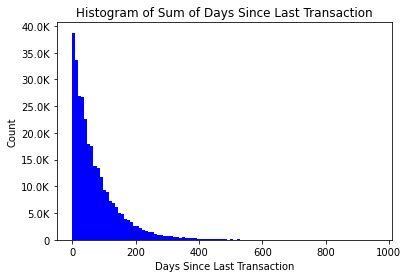

In [0]:
#plotting the histogram of the days_since_last_txn
fig, ax = plt.subplots()
hist(ax, last_monthly_purchase_base.select('days_since_last_txn'), bins = 100, color=['blue'])
plt.xlabel("Days Since Last Transaction")
plt.ylabel("Count")
plt.title("Histogram of Sum of Days Since Last Transaction")
plt.show()

Given that there are only 17531 NaN values compared to the 300+k entries, a backfill method was used to impute the initial data and do not affect the overall distirbution (seen below)

In [0]:
# performing a backfill on days_since_last_txn
last_monthly_purchase_base = last_monthly_purchase_base.withColumnRenamed('days_since_last_txn', 'days_since_last_txn_1')
bfill_window = Window.partitionBy('CLNT_NO')\
               .orderBy('ME_DT')\
               .rowsBetween(0, sys.maxsize)

bfilled = first(last_monthly_purchase_base.days_since_last_txn_1, ignorenulls = True).over(bfill_window)

last_monthly_purchase_base = last_monthly_purchase_base.withColumn('days_since_last_txn', bfilled).drop('days_since_last_txn_1')

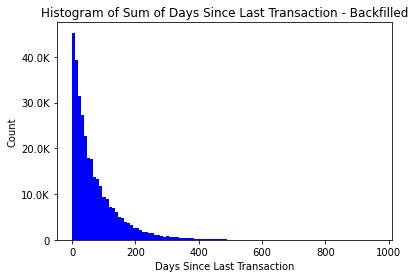

In [0]:
#re-plotting after the backfill
fig, ax = plt.subplots()
hist(ax, last_monthly_purchase_base.select('days_since_last_txn'), bins = 100, color=['blue'])
plt.xlabel("Days Since Last Transaction")
plt.ylabel("Count")
plt.title("Histogram of Sum of Days Since Last Transaction - Backfilled")
plt.show()

In [0]:
new_monthly = last_monthly_purchase_base.drop('last_monthly_purchase')

In [0]:
# new_monthly.coalesce(1).write.format("com.databricks.spark.csv").save("/FileStore/tables/days_since_last_txn.csv", header = 'true')